### Introduction

This demo shows how a particle filter algorithm (sequential Monte-Carlo sampling) can fit hyperparameters of a Gaussian process for a set of observations $\{x_i,z_i\}$. 
The model of observations is $z_i = x_iw_i + \eta$ , where $\eta \sim N(0,s^2)$ , and _w_ is a latent variable that changes with _i_ according to a random walk dynamics $\xi = w_{i+1} - w_{i} ; \xi \sim N(0,\sigma^2)$ ; where $\sigma$ is volatility of random walk (std of updates). 

The task is to fit _s_ and $\sigma$. The algorithm used here is taken from Svensson et al., Marginalizing Gaussian Process Hyperparameters Using Sequential Monte Carlo, arXiv 2015;

The algorithm is implemented in partguide_exp and is as follows: (0) partition the data $\{x_i,z_i\}$ on P parts (1) sample candidate value pairs (particles) $(\sigma,s)$ from a prior distribution (2) for every particle, compute its log marginal likelihood (LML) given the data from "current" dataset (which includes all partitions from 0-th to p-th) and compute LML from "next" dataset (all partitions from 0-th to (p+1)-th) (3) compute exp(LML1/LML2), normalize and use as weights for existing particles (4) resample existing particles according to their weights using multinomial sampling (5) using a proposal distribution centered on available particles, generate proposal values of $(\sigma,s)$  (6) compute LML for each proposed and its seeding particle, and keep the proposed particle if its LML is larger, dataset is fixed to {0..p+1} data partitions; (7) repeat from (2) for the next iteration of data expansion 

After the $(\sigma,s)$ are found, latend variable _w_ can be found by maximizing posterior (currently not shown).

#### Contents

In the following we simulate data (simpfdata), plot the latent weights (w) and observations (z), set up the parameters of the sequential Monte Carlo and run it using "partguide_exp", which also plots the distribution of candidate particles for every iteration over data partitions. 

#### Figures generated by partguide_exp

The prior on $\{\sigma,s\}$ is centered at log10(1) and variance of log10(1) - the prior is always plotted as contours. The initial sample of particles is shown on the first plot in blue dots. This plot also shows the progression of "final" particles at each data-iteration as "+" of different colors. The ground truth for $\{\sigma,s\}$ is (-1,-1) in the log space where plots are shown. One can see that "+" approach this point. 
The following plots show seeding, proposed, and accepted particles within every data iteration - with blue circles, empty black circles, and "+" signs respectively. One can see that the accepted "+" particles gradually approach the (-1,1) value.

In [1]:
from pf_utils import simpfdata
params = {'N':200, 'sgma':0.1, 's':0.1, 'krnlen':1}

In [2]:
simdata = simpfdata(N=params['N'], sgma=params['sgma'], s=params['s'], krnlen=params['krnlen'], randomSeed=1)

Text(0.5, 1.0, 'dynamic weights w_i')

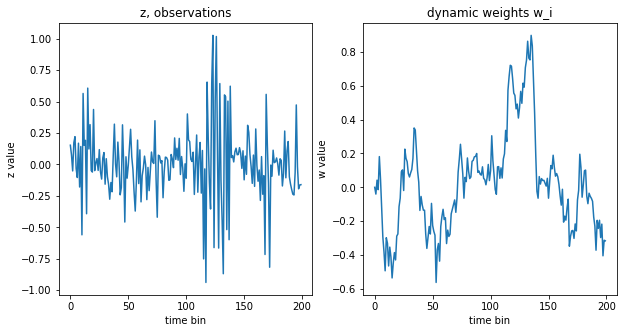

In [3]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(simdata['z'])
ax[0].set_xlabel('time bin')
ax[0].set_ylabel('z value')
ax[0].set_title('z, observations')

ax[1].plot(simdata['k'])
ax[1].set_xlabel('time bin')
ax[1].set_ylabel('w value')
ax[1].set_title('dynamic weights w_i')

In [4]:
# set parameters of particle filter and prior

import numpy as np
from scipy.stats import multivariate_normal as mvn

ind_perm = np.random.permutation(params['N']) # shuffle the order of trials so that trials are evenly sampled for all partitions 
P = 10 # number of partitions
N_part = 15 # number of particles

# prior and its parameters 
pri_mean_log = [0, 0]# mean of the prior on parameter values; log10(sgma=1) and log10(s=1)
pri_cov_log = [[1,0],[0,1]]# cov of the log10 of sgma and s
f_prior_rnd = mvn(pri_mean_log,pri_cov_log)
f_prior = lambda sgma,s: f_prior_rnd.pdf([sgma,s])

# sample particles from the prior
rng = np.random.default_rng()
particles = np.zeros((2,N_part,P+1))
particles[:,:,0] = rng.multivariate_normal( pri_mean_log , pri_cov_log , size=N_part).T


params_pf = {'P': P, 'ind_perm': ind_perm, 'N_part':N_part, 'particles':particles, 'proposal_var':0.1}

data partition 1 of 10...
data partition 2 of 10...
data partition 3 of 10...
data partition 4 of 10...
data partition 5 of 10...
data partition 6 of 10...
data partition 7 of 10...
data partition 8 of 10...
data partition 9 of 10...
data partition 10 of 10...


C:\Users\Dmitry\Documents\Python Scripts\state_model\partfilt\model.py:276: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
C:\Users\Dmitry\Documents\Python Scripts\state_model\partfilt\model.py:140: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

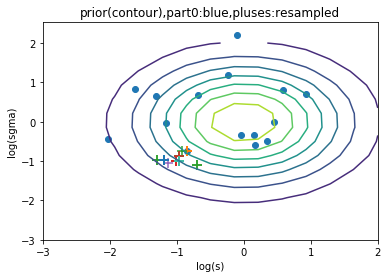

<Figure size 432x288 with 0 Axes>

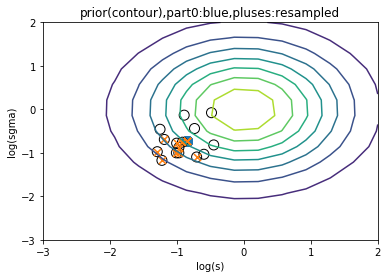

<Figure size 432x288 with 0 Axes>

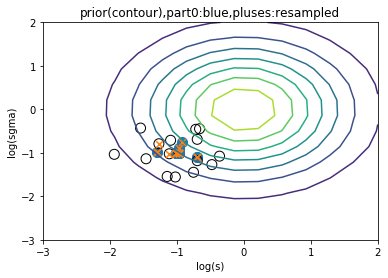

<Figure size 432x288 with 0 Axes>

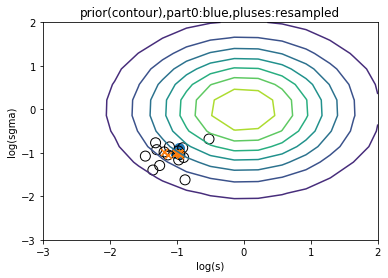

<Figure size 432x288 with 0 Axes>

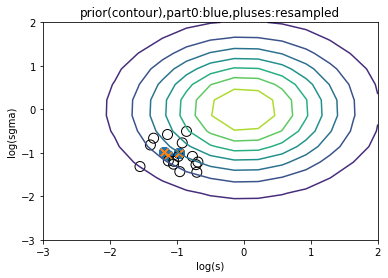

<Figure size 432x288 with 0 Axes>

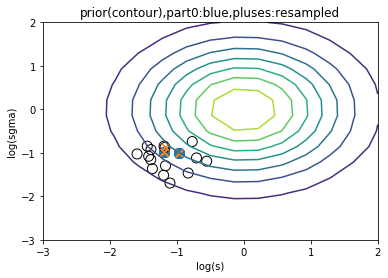

<Figure size 432x288 with 0 Axes>

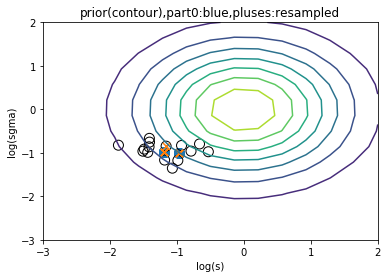

<Figure size 432x288 with 0 Axes>

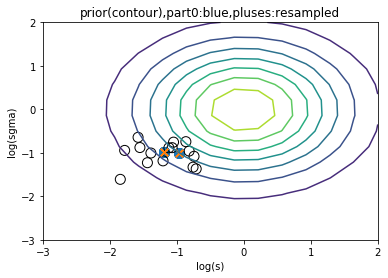

<Figure size 432x288 with 0 Axes>

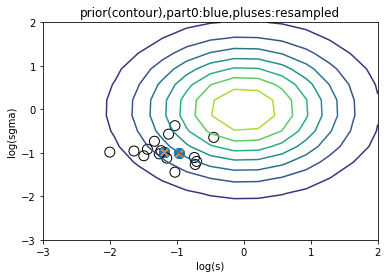

<Figure size 432x288 with 0 Axes>

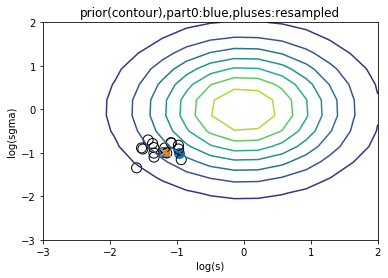

<Figure size 432x288 with 0 Axes>

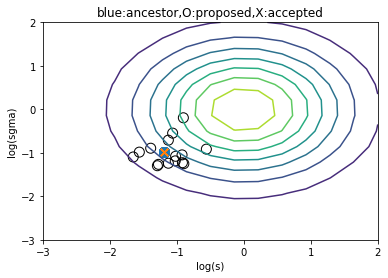

In [5]:
from model import partguide_exp

particles_out = partguide_exp(simdata, params, params_pf, f_prior, do_plot=True)